In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
from torch.utils.data import random_split,DataLoader
import string
from PIL import Image
import matplotlib.pyplot as plt
import time
import shutil
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [61]:
USE_CUDA = torch.cuda.is_available()

print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))
device = torch.device("cuda" if USE_CUDA else "cpu")
cpu_device = torch.device("cpu")

BATCH_SIZE=128
VAL_SPLIT=0.2

AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=4

CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26+10
OUTPUT_LENGTH=6

SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS=40
epoch_count = [i for i in range(1,EPOCHS+1)]

train_acc=[]
test_acc=[]

Device : GPU


In [18]:
data = '/kaggle/input/captchaimgdata/trainset'

In [19]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import string
import zipfile

def get_dataloaders(data_dir, batch_size=32, val_split=0.2, shuffle=True, num_workers=0):
    # Define the character set (vocabulary)
    characters = string.ascii_uppercase + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0].upper() for f in self.image_paths]  # Extract filename as label

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]

            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding

            if self.transform:
                image = self.transform(image)

            return image, label_tensor

    transform = transforms.Compose([
        transforms.Resize((192,64)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])

    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    print(f"Dataset size: {len(dataset)}")  # Print dataset size

    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [20]:
train_loader,val_loader=get_dataloaders(data_dir= data, batch_size=BATCH_SIZE, val_split=0.2, shuffle=True)

Dataset size: 26155


In [21]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 192, 64]), torch.Size([128, 6]))

In [22]:
#def accuracy_fn(y_true, y_pred):
        #correct = torch.eq(y_true, y_pred).sum().item()
        #acc = (correct / len(y_true))
        #return acc
def accuracy_fn(y_true, y_pred):
            y_true = y_true.cpu()  
            y_pred = y_pred.cpu()

            y_true = y_true.view(-1)  
            y_pred = y_pred.view(-1)  

            correct = torch.eq(y_true, y_pred).sum().item()
            total_samples = len(y_true) 

            acc = (correct / total_samples)*100
            return acc

In [23]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )
class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [24]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)

        #During training, the values of alpha are adjusted by the optimizer to learn the optimal feature fusion strategy. If alpha[i] is close to 0,
        #the network emphasizes the direct path.
        #If alpha[i] is close to 1, it emphasizes the residual path.
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i])
                residuals.append(x * self.alpha[i])

        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:
                x = x + residuals.pop()

        return x

In [25]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)

        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)

        outputs = []

        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 6, vocab_size)

        return outputs


In [26]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [62]:
def train(model,train_loader,val_loader,epochs=EPOCHS):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    train_history=[]
    val_history=[]
    train_acc=[]
    val_acc=[]
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        avg_acc=0
        avg_loss=0
        model.train()
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):

            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)

            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()

            avg_loss+=loss.item()
            avg_acc+=accuracy_fn(y_true=y.cpu(),y_pred=torch.argmax(preds,dim=2).cpu())


        avg_loss/=len(train_loader)
        avg_acc/=len(train_loader)
        train_acc.append(avg_acc)
        print(f"Train Acc: {avg_acc}%")
        train_history.append(avg_loss)
        print(f"Train Loss: {avg_loss}")

        eval_loss=0
        eval_acc=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
                    eval_acc+=accuracy_fn(y_true=y,y_pred=torch.argmax(preds,dim=2))
                    eval_loss+=loss.item()
                eval_acc/=len(val_loader)
                val_acc.append(eval_acc)
                print(f"Val Acc: {eval_acc}%")
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}")


        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')

    return train_history,val_history,train_acc,val_acc




In [63]:
model=CaptchaCrackNet().to(device)

train_history,val_history,train_acc,val_acc =train(model,train_loader,val_loader,EPOCHS)

Epoch 1:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 11.684821731029814%
Train Loss: 3.384552669234392


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 14.084015417856879%
Val Loss: 3.302349561598243
Epoch 2:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 14.569200965447147%
Train Loss: 3.2536532355517878


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 15.427613207719915%
Val Loss: 3.2203702403277887
Epoch 3:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 15.79665269308943%
Train Loss: 3.179280218554706


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 16.015138614223982%
Val Loss: 3.182160546139973
Epoch 4:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 16.86531377032521%
Train Loss: 3.117548554408841


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 17.205553495568736%
Val Loss: 3.1265393582786003
Epoch 5:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 17.948001355013545%
Train Loss: 3.065999531164402


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 16.282393292682922%
Val Loss: 3.1050693698045686
Epoch 6:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 18.745818512872646%
Train Loss: 3.0206413283580686


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 17.360681947191093%
Val Loss: 3.0417266938744523
Epoch 7:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 19.69178734756097%
Train Loss: 2.977837348856577


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 19.41028299641105%
Val Loss: 2.9958212084886506
Epoch 8:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 20.483835111788625%
Train Loss: 2.9371934067912218


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 20.474409241558625%
Val Loss: 2.94815758961003
Epoch 9:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 21.067549542682936%
Train Loss: 2.9012904966749797


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 20.861372042774477%
Val Loss: 2.9088051958781915
Epoch 10:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 21.517403455284548%
Train Loss: 2.8707482349581834


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 20.774394821650915%
Val Loss: 2.8943072179468667
Saving model
Epoch 11:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 21.965881182249316%
Train Loss: 2.842087720952383


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 21.319175501721237%
Val Loss: 2.880866248433183
Epoch 12:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 22.3633871104336%
Train Loss: 2.815631257324684


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 20.617807212700505%
Val Loss: 2.849502639072697
Epoch 13:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 22.671705623306234%
Train Loss: 2.7896437746722524


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.170035889548082%
Val Loss: 2.813368419321572
Epoch 14:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 22.95864032859078%
Train Loss: 2.76344235350446


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.566755017212333%
Val Loss: 2.780504197609134
Epoch 15:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 23.305544969512205%
Train Loss: 2.739173354172125


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.40038247088553%
Val Loss: 2.7922712128336835
Epoch 16:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 23.64895621612465%
Train Loss: 2.7158885321966033


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.65567778143998%
Val Loss: 2.7669407507268393
Epoch 17:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 23.97834095528456%
Train Loss: 2.6929383714024615


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 23.04824832454406%
Val Loss: 2.757682189708803
Epoch 18:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 24.1430597899729%
Train Loss: 2.671729926655932


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 23.26883857943309%
Val Loss: 2.705930081809439
Epoch 19:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 24.51595316734417%
Train Loss: 2.6502195698458975


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 23.5131186827071%
Val Loss: 2.6928710065236907
Epoch 20:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 24.899750169376688%
Train Loss: 2.627032800418575


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 23.78623860140629%
Val Loss: 2.6892900059862836
Saving model
Epoch 21:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 25.301014142953928%
Train Loss: 2.6062996271179943


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 24.480024994506703%
Val Loss: 2.653686971199222
Epoch 22:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 25.521309705284565%
Train Loss: 2.585162029033754


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 24.778780304694937%
Val Loss: 2.6441217631828495
Epoch 23:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 25.86615006775069%
Train Loss: 2.5654254381249593


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 24.710142688420127%
Val Loss: 2.6363923317048608
Epoch 24:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 26.32542555894308%
Train Loss: 2.543056845664978


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 25.296437825020142%
Val Loss: 2.6126828426268043
Epoch 25:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 26.738598831300813%
Train Loss: 2.5225108062348713


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 25.612788855929093%
Val Loss: 2.5904231187773914
Epoch 26:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 27.094766260162597%
Train Loss: 2.5029034818091045


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 26.04761773969091%
Val Loss: 2.574102628521803
Epoch 27:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 27.451145409891595%
Train Loss: 2.4821105773856


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 26.331724254742547%
Val Loss: 2.556366891395755
Epoch 28:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 27.951759400406505%
Train Loss: 2.4613610622359485


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 26.516665293342125%
Val Loss: 2.5443056850898556
Epoch 29:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 28.307344596883468%
Train Loss: 2.439787604459902


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 27.002307185234013%
Val Loss: 2.51000393890753
Epoch 30:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 28.78773924457993%
Train Loss: 2.419531484929527


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 27.5072328425987%
Val Loss: 2.4928250022050813
Saving model
Epoch 31:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 29.235264227642276%
Train Loss: 2.398193719910412


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 27.892507599062473%
Val Loss: 2.476640166305914
Epoch 32:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 29.676172933604327%
Train Loss: 2.377275503263241


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 28.57576517065846%
Val Loss: 2.4550670298134407
Epoch 33:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 30.147939955962052%
Train Loss: 2.3564121359732093


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 28.587495651138948%
Val Loss: 2.440878705280583
Epoch 34:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 30.533642445799448%
Train Loss: 2.335990599015864


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 28.861588341390167%
Val Loss: 2.4456212113543256
Epoch 35:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 31.031874576558256%
Train Loss: 2.314556021515916


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 29.30425661942431%
Val Loss: 2.411941993527296
Epoch 36:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 31.542174796747986%
Train Loss: 2.2938307436501106


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 29.612539368636934%
Val Loss: 2.391436739665706
Epoch 37:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 32.08349212398374%
Train Loss: 2.2693569689262203


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 30.277257058888154%
Val Loss: 2.371101181681563
Epoch 38:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 32.47771637872627%
Train Loss: 2.24882719574905


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 30.674233684904422%
Val Loss: 2.356242092644296
Epoch 39:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 33.02887872628725%
Train Loss: 2.227693054734207


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 30.931703425986957%
Val Loss: 2.339051235012892
Epoch 40:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 33.41140540311655%
Train Loss: 2.2084013688855055


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 31.789888211382106%
Val Loss: 2.3150887605620594
Saving model


In [46]:
# 1. Instantiate the model
loaded_model = CaptchaCrackNet() 

# 2. Load the state dictionary
#Replace 'final.pth' or '10.pth' with your actual saved file name
state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_location=torch.device('cpu')

# 3. Load the state dictionary into the model
loaded_model.load_state_dict(state_dict) 

# Set the model to evaluation mode
loaded_model.eval()

/tmp/ipykernel_31/2187190862.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_lo

CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

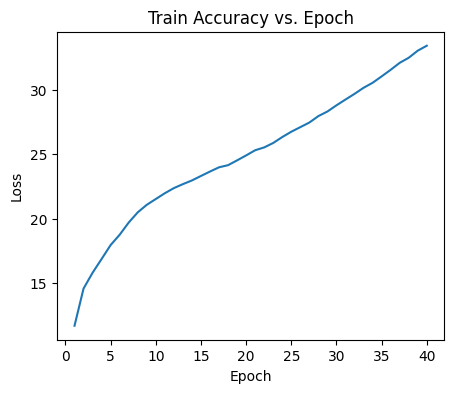

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(epochs,losses,predictions=None):
  plt.figure(figsize=(5,4))
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train Accuracy vs. Epoch')
  plt.show()
plot_predictions(epoch_count,train_acc)

In [65]:
characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans


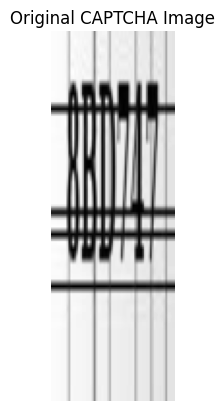

tensor([[ 1,  1, 33, 33, 33, 33]], device='cuda:0')
True : 8BD747
Pred : BB7777


In [94]:
from itertools import groupby

characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

import matplotlib.pyplot as plt

model.eval()  # Set to eval mode

with torch.no_grad():
    for X, y in train_loader:
        # Select one sample
        X_single = X[0]
        y_single = y[0]

        # Show original image
        plt.imshow(X_single.numpy().squeeze(), cmap='gray')
        plt.title("Original CAPTCHA Image")
        plt.axis("off")
        plt.show()

        # Model output
        input_tensor = X_single.unsqueeze(0).to(device)
        output = model(input_tensor)  # [W, B, VOCAB_SIZE]
        output = F.log_softmax(output, dim=2)
        pred = output.argmax(dim=2).squeeze(1)  # [W]
        print(pred)
        # Decode prediction
        pred_text=''
        for i in pred:
            pred_text+= to_text(i)
        true_text = ''.join([idx_to_char[c.item()] for c in y_single if c.item() != -1])

        print(f"True : {true_text}")
        print(f"Pred : {pred_text}")
        break